# CKP8087 - Estrutura de Dados
<img  src="https://img.shields.io/badge/UFC_CKP8087-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" /> 

### Bibliotecas principais

In [1]:
import numpy as np
import pandas as pd

import networkx as nx
import random as rnd

from itertools import product
from functools import reduce

import matplotlib.pyplot as plt

### Loading

In [12]:
df = pd.read_csv('../lista-2/files/dados.csv')
df.rename(columns={'score_sentiment': 'sentiment', 'score_misinformation': 'misinformation'}, inplace=True)

# Flag de viral
counts = df['text'].value_counts()
df['isviral'] = df['text'].isin(counts[counts > 1].index)

# Flaf de misinformation
df['ismisinformation'] = df.misinformation >= 0.7

df.shape

(186316, 7)

In [13]:
# Separação dos grafos
geral  = df[['member', 'group', 'isviral', 'ismisinformation']]
viral = geral[geral.isviral]
misin = geral[geral.ismisinformation]

## Parte I - NetworkX

https://networkx.org/

#### Funções

In [14]:
# Função de montagem do grafo
def networkX(df, color="#390099"): # ff0054, ffbd00
    graph = {} # Faster than working with networkX
    G = nx.Graph()
    
    for group in df.group.unique(): 
        members = df[df.group == group].member.value_counts()
        
        for s in members.keys():
            for r in members.keys():
                # Avoiding duplicates and self edges
                if s == r or (s in graph and r in graph and (s in graph[r] or r in graph[s])):
                    continue
    
                # Control
                graph[s] = graph.get(s, [])
                graph[s].append(r)
                
                # Real deal
                G.add_edge(s, r, color=color)

    return nx.convert_node_labels_to_integers(G, first_label=1, label_attribute='original')

In [15]:
# Função de remoção das arestas
def remove_edges(G, perc=0.1):
  n_edges = G.number_of_edges()
  size = int(n_edges * perc)
  ebunch = rnd.choices(list(G.edges), k=size)
  
  H = G.copy()
  H.remove_edges_from(ebunch)
  
  return H, nx.Graph(ebunch)


In [16]:
# Métrica: Graph Distance
def graph_distance_fn(G, ebunch):
  distances = []
  for  u, v in ebunch:  
    try:
      distance = -nx.shortest_path_length(G, u, v)
    except:
      distance = 0
    finally:
      distances.append((u, v, distance))
  
  return distances

#
nx.graph_distance = graph_distance_fn

In [23]:
# Métrica: Katz Score
def katz_score_fn(G, ebunch, beta=0.05, max_node_length=2):
  scores = []
  for  u, v in ebunch:  
    # List of possible paths
    paths = list(nx.all_simple_paths(G, u, v, cutoff=max_node_length))
    
    # Counts per path length
    counts = {i:0 for i in range(1, max_node_length + 2)}
    
    for p in paths:
      counts[len(p)] += 1
      
    kats_score = 0
    for l, count in counts.items():
      kats_score += beta**l * count
    
    scores.append((u, v, kats_score))
    
  return scores

nx.katz_score = katz_score_fn

### Metodologia

- Encontrar o maior component conectado
- Remover 10% de suas arestas aleatóriamente
- Usar os algoritmos e ordenar os _scores_
- Verificar a usabilidade das métricas

#### Métricas de predição de ligação

| Métrica | Suporte | |
| -- | -- | -- |
| Preferential attachment | `nativo` | `preferential_attachment()` |
| Common neighbors | `nativo` | `common_neighbors_centrality()` |
| Jaccard | `nativo` | `jaccard_coefficient()`|
| Adamic-Adar | `nativo` | `adamic_adar_index()` |
| Graph distance | `desenvolvido` |
| Katz | `nativo` | `katz_centrality()` |

https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

In [18]:
# Montando os grafos
%time gg = networkX(geral)
%time gv = networkX(viral)
%time gm = networkX(misin)

CPU times: user 4.89 s, sys: 88.3 ms, total: 4.97 s
Wall time: 5.02 s
CPU times: user 2.12 s, sys: 30.7 ms, total: 2.15 s
Wall time: 2.16 s
CPU times: user 268 ms, sys: 5.88 ms, total: 273 ms
Wall time: 274 ms


In [110]:
def run(G, perc=0.1, seed=42, verbose=False):
  # Seed
  rnd.seed(seed)

  # Get giant component
  if verbose: print('Giant component...')
  giant = G.subgraph(max(nx.connected_components(G), key=len))
  nodes = list(giant.nodes)

  # Remove 10% of the edges
  if verbose: print('Removing edges...')
  gbase, gremoved = remove_edges(giant, perc=perc)

  # Get missing edges
  emiss = list(filter(lambda x: x[0] != x[1], product(nodes, nodes)))
  emiss = list(set(emiss).difference(giant.edges)) # better than using nx

  # Preferential Attachment
  if verbose: print('Preferential Attachment...')
  preferential_attachment = list(nx.preferential_attachment(gbase, emiss))

  # Common Neighbors
  if verbose: print('Common Neighbors...')
  common_neighbor = list(nx.common_neighbor_centrality(gbase, emiss))

  #  Jaccard Coefficient
  if verbose: print('Jaccard Coefficient...')
  jaccard_coefficient = list(nx.jaccard_coefficient(gbase, emiss))

  # Adamic-Adar 
  if verbose: print('Adamic-Adar...')
  adamic_adar_index = list(nx.adamic_adar_index(gbase, emiss))

  # Graph Distance 
  if verbose: print('Graph Distance...')
  graph_distance = list(nx.graph_distance(gbase, emiss))

  # Katz Score 
  if verbose: print('Katz Score...')
  katz_score = list(nx.katz_score(gbase, emiss))

  # Joining data
  df = pd.DataFrame(
    np.c_[
      np.array(emiss), 
      np.array(preferential_attachment)[:, 2], 
      np.array(common_neighbor)[:, 2],
      np.array(jaccard_coefficient)[:, 2], 
      np.array(adamic_adar_index)[:, 2],
      np.array(graph_distance)[:, 2],
      np.array(katz_score)[:, 2]
    ], 
    columns=['sender', 'receiver', 'p_attach', 'c_neighbor', 'jacc_coef', 'adamic_adar', 'graph_distance', 'katz_score']
  )

  # Marking removed edges
  df['isremoved'] = False

  for u, v in gremoved.edges:
    df.loc[((df.sender == u) & (df.receiver == v)) | ((df.sender == v) & (df.receiver == u)), 'isremoved'] = True
    
  # Setting uniform weights for each removed edge
  df['weight'] = 0.0
  df.loc[df.isremoved, 'weight'] = 1/gremoved.number_of_edges()

  return df

In [112]:
G = nx.barbell_graph(10, 5)
seed = 42
perc= 0.25
verbose = True

df = run(G, perc, seed, verbose)

Giant component...
Removing edges...
Preferential Attachment...
Common Neighbors...
Jaccard Coefficient...
Adamic-Adar...
Graph Distance...
Katz Score...


In [124]:
# Prepering data
cols = ['p_attach', 'c_neighbor', 'jacc_coef', 'adamic_adar', 'graph_distance', 'katz_score']
labels = ['Preferential Attachment', 'Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar', 'Graph Distance', 'Katz Score']
cumsums = []
achieved_at = []

for col in cols:
  cumsum = df.sort_values(col, ascending=False)['weight'].cumsum().to_numpy()
  cumsums.append(cumsum)
  achieved_at.append(np.min(np.where(cumsum == max(cumsum))))
  
best = np.argmin(achieved_at)
labels[best]

'Jaccard Coefficient'

In [138]:
len(cols), len(labels), len(cumsums), len(achieved_at), best

(6, 6, 6, 6, np.int64(2))

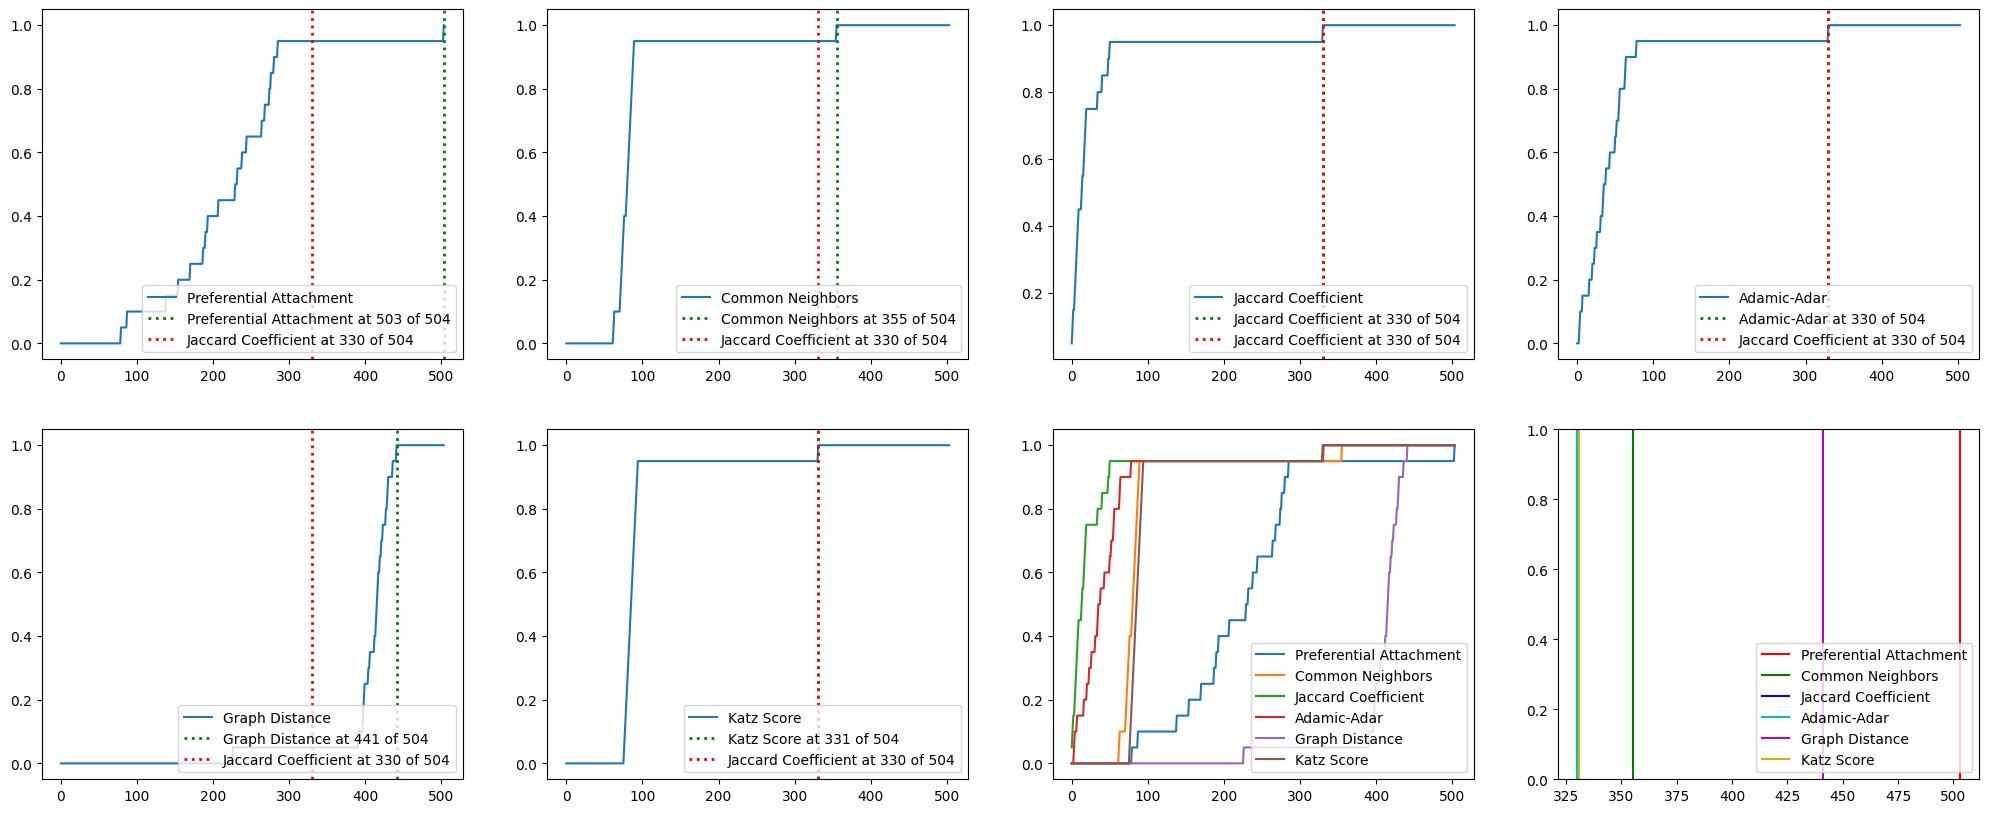

In [ ]:
# Plot
x = np.arange(df.shape[0])
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

m = 0
for r in range(2):
  for c in range(4):
    # Safety
    if m >= len(cumsums): 
      break
    
    # Plot
    axs[r][c].plot(x, cumsums[m], label=labels[m])
    axs[r][c].axvline(x = achieved_at[m], color="g", linestyle=':', linewidth=2, label=f'{labels[m]} at {achieved_at[m]} of {df.shape[0]}')
    axs[r][c].axvline(x = achieved_at[best], color="red", linestyle=':', linewidth=2, label=f'{labels[best]} at {achieved_at[best]} of {df.shape[0]}')
    axs[r][c].legend(loc="lower right")
    
    #
    m += 1
    
# All lines
colors = ['b', 'orange', 'g', 'r', 'purple', 'brown']
for i in range(len(cols)):
  axs[1][2].plot(x, cumsums[i], label=labels[i])
  axs[1][3].axvline(x=achieved_at[i], label=labels[i], color=colors[i])
  
axs[1][2].legend(loc="lower right")
axs[1][3].legend(loc="lower right")
  

# axs[0][1].plot(x, c_neighbor_cs, label='Common Neighbors')
# axs[0][1].legend(loc="lower right")

# axs[0][2].plot(x, jacc_coef_cs, label='Jaccard Coefficient')
# axs[0][2].legend(loc="lower right")

# axs[0][3].plot(x, adamic_adar_cs, label='Adamic-Adar')
# axs[0][3].legend(loc="lower right")

# axs[1][0].plot(x, graph_distance_cs, label='Graph Distance')
# axs[1][0].axvline(x = np.min(np.where(graph_distance_cs == max(graph_distance_cs))), color="g", linestyle=':', linewidth=2, label='Graph Distance')
# axs[1][0].legend(loc="lower right")


# axs[1][1].plot(x, katz_score_cs, label='Katz Score')
# axs[1][1].legend(loc="lower right")


In [84]:
axs[1][0].plot(x, graph_distance_cs, label='Graph Distance')
axs[1][0].legend(loc="lower right")

axs[1]

np.int64(441)

In [104]:
max([(10, 'a'), (10, 'c'), (11, 'd')])

(11, 'd')